<font size="6"> Table of Contents</font>
<a id='destination_cell_10'></a> <br>
[Section 1](#destination_cell_1) <br><blockquote>
        1) Imports<br>
        2) Snakecase and lowercase column names<br>
        3) Null counts<br>
        4) Summary Statistics<br>
        5) Overview of the data<br> </blockquote>
[Section 2](#destination_cell_2)<br><blockquote>
        1) Pairplots<br>
        2) Identify erroneous values vs outlier values<br>
        3) Drop all observations that are not zoned as medium or low density residential housing (out of scope observations)<br>
        4) Drop "pid" and "id" columns as they cannot be features of the target variable<br>
        5) Drop observations for columns that have less than 3 null values<br>
        6) Drop Columns with more than 105 nulls<br> </blockquote>
[Section 3](#destination_cell_3)<br><blockquote>
        1) Evaluate distributions for features we will impute values for<br>
        2) Heatmap<br></blockquote>
[Section 4](#destination_cell_4)<br><blockquote>
        1) Set x and y<br>
        2) split data into train and validation sets<br>
        3) Impute values for trainning set<br>
        4) Impute values for validation set<br></blockquote>
[Section 5](#destination_cell_5)<br><blockquote>
        1) Columntransformer<br>
        2) One Hot Encode<br>
        3) Standard Scalar<br></blockquote>
[Section 6](#destination_cell_6)<br><blockquote>
        1) Linear Regression<br>
        2) Coefficient Equation<br>
        3) Comfrot over Assumptions<br>
        4) Evaluate Results<br></blockquote>
[Section 7](#destination_cell_7)<br><blockquote>
        1) Ridge Regression<br>
        2) Comfrot over Assumptions<br>
        3) Evaluate Results<br></blockquote>
[Section 8](#destination_cell_8)<br><blockquote>
        1) LASSO Regression<br>
        2) Comfrot over Assumptions<br>
        3) Evaluate Results<br></blockquote>
[Section 9](#destination_cell_9)<br><blockquote>
        1) Elastic Regression<br>
        2) Comfrot over Assumptions<br>
        3) Evaluation Results<br></blockquote>

        





<font size="8">Section 1</font>
<a id='destination_cell_1'></a>

[Return to Table of Contents](#destination_cell_10)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats 
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.linear_model import ElasticNet
from scipy.stats import mstats


In [2]:
%cd /Users/nicholassanso/Desktop/GA/projects/project-2

/Users/nicholassanso/Desktop/GA/projects/project-2


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [4]:
df= pd.read_csv('./datasets/train.csv')
df_test = pd.read_csv('./datasets/test.csv')

In [5]:
new_columns = [column.replace(' ', '_').replace('/', '_').lower() for column in df.columns]

df.columns = new_columns
print(new_columns)

['id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style', 'overall_qual', 'overall_cond', 'year_built', 'year_remod_add', 'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional', 'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_blt', 'garage_finish', 'garage_cars', 'garage_area', 'garage_qual', 'garage_cond', 'paved_drive', 'wood_deck_sf'

**Exclude ms_zoning variables from all the dataframes because it is a completely different regression variable <br>
Exclude garage_cars because it measures in a metric, "length of car" which is a nonstandardized and meaningless metric (we also already have garage_area which measures a something very similar)**

In [6]:
df_size = df[['saleprice', 'misc_val', 'lot_frontage', 'lot_area', 'bsmtfin_sf_2', 'bsmt_unf_sf', 
              'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'garage_area', 'wood_deck_sf',
              'open_porch_sf', 'enclosed_porch', 'pool_area', 'screen_porch', '3ssn_porch']].copy()

df_quality_of_house_vars = df[['saleprice', 'misc_val', 'overall_qual', 'overall_cond', 'exter_qual',
                               'exter_cond','bsmt_qual', 'bsmt_cond', 'bsmtfin_type_1', 'bsmtfin_type_2', 
                               'kitchen_qual', 'functional', 'fireplace_qu','garage_qual', 'garage_finish', 
                               'garage_cond', 'fence', 'pool_qc']].copy()

df_age_vars = df[['saleprice', 'misc_val', 'year_built', 'year_remod_add', 'garage_yr_blt', 
                  'yr_sold','mo_sold']].copy()

df_roommage_vars = df[['saleprice','misc_val','bsmt_full_bath','bsmt_half_bath','full_bath','half_bath',
                       'bedroom_abvgr','kitchen_abvgr', 'totrms_abvgrd','fireplaces']].copy()

df_environment_vars = df[['saleprice','misc_val','street','alley','neighborhood']].copy()


df_categories_of_house_vars = df[['saleprice','misc_val','roof_style','roof_matl','exterior_1st',
                                  'exterior_2nd','mas_vnr_type', 'foundation','bsmt_exposure','heating','heating_qc',
                                  'central_air','electrical','garage_type','paved_drive', 'ms_subclass',
                                  'bldg_type','lot_shape','land_contour','utilities', 'lot_config',
                                      'land_slope','condition_1','condition_2','house_style']].copy()



#df_categories_of_house_vars_MIN_MAX_ORDINALencode= df[[ bsmt_exposure, heating_qc

#df_categories_of_house_vars_OHE= df[[roof_style, roof_matl, exterior_1st, exterior_2nd, mas_vnr_type, 
#foundation, heating, central_air, electrical, garage_type,paved_drive, ms_subclass, bldg_type, lot_shape,
#land_contour, utilities, lot_config, land_slope, land_contour, condition_1, condition_2


In [7]:
df['misc_feature'].value_counts()

Shed    56
Gar2     4
Othr     3
TenC     1
Elev     1
Name: misc_feature, dtype: int64

In [8]:
df['misc_val'].value_counts()

0        1986
400        12
500         8
600         6
450         5
2000        5
700         4
1200        2
3000        2
2500        2
4500        2
17000       1
1300        1
900         1
1500        1
800         1
6500        1
54          1
3500        1
1150        1
300         1
455         1
8300        1
460         1
12500       1
480         1
650         1
80          1
Name: misc_val, dtype: int64

Ultimately we would like to predict the sales price of a house.<br> 

Embedded in some (65) of our sales price datapoints is the value of miscellanious features. misc_features is unique in the datatset as it is the only feature of a house in which we are also given its exact monetary value (and therefore contribution to the target variable, salesprice). As a result, we can get a more acurate understanding of the relationship between our predictor variables and our target variable (saleprice) if we remove the value of the miscellanious features from saleprice, as leaving its value in saleprice would serve as a counding variable. After removing the value of the miscellanious features from saleprice, we are no longer strictly predicting saleprice, but the portion of saleprice that is not attributable to the miscellanious features. <br>

Subtracting the value of the miscelanious features provides the additional benefit of not losing the predictive power of the the miscelanious variables in predicting salesprice and not having to incorporate a predictive variable in which the vast majority of its values are imputed. The histograms below underscroe this point and allow illustrate two conclusions: <br> 
1) The miscellanious features are mostly sheds of nominal value <br> 
2) Most of our observations don't have a miscellanious value <br> 
    2.a. If we included miscellanious feature as a our regression we would have to impute values for the nulls which comprise the vast majority of our obsevations. <br>

From these two conclusions, it is probably best to drop these two features altogether.

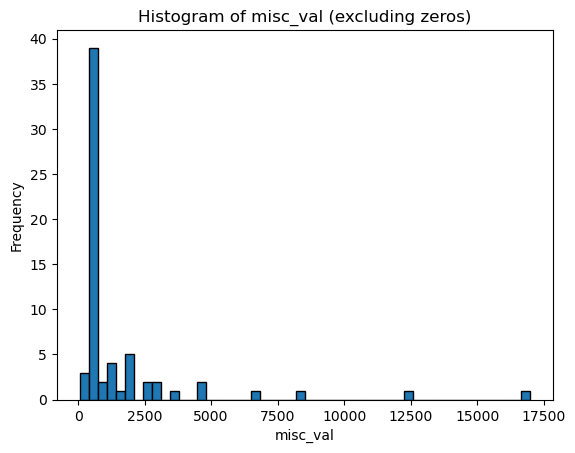

In [9]:
#Use the y-axis to gauge how few observations actually have miscellanious features and how many of the miscellanious features are of nominal value.

df_no_zeros = df[df['misc_val'] != 0]

plt.hist(df_no_zeros['misc_val'], bins=50, edgecolor='black')
plt.title('Histogram of misc_val (excluding zeros)')
plt.xlabel('misc_val')
plt.ylabel('Frequency')
plt.show()


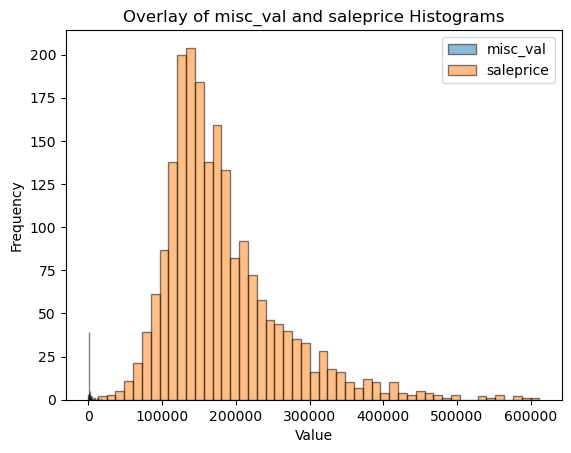

In [11]:
#plot the two histograms overlayed on one another to visually represent how immaterial misc_val is to saleprice as part of the justification for dropping the 
#feature from the regression model.

plt.hist(df_no_zeros['misc_val'], bins=50, edgecolor='black', alpha=0.5, label='misc_val')
plt.hist(df['saleprice'], bins=50, edgecolor='black', alpha=0.5, label='saleprice')

plt.title('Overlay of misc_val and saleprice Histograms')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()

**Some of the houses have high value miscelanious features like elevators. However, there is another feature, misc_value which specifically denotes the dollar amount of these features" so when training our model, we don't actually want to train it to predict saleprice, we want it to train to predict saleprice-misc_val, and then if a miscellanious item exists, to add on the value of the miscelleanious item at the end.**

In [12]:
def add_new_column(df):
    df['saleprice-misc_val'] = df['saleprice'] - df['misc_val']
    return df

df_size = add_new_column(df_size)
df_quality_of_house_vars = add_new_column(df_quality_of_house_vars)
df_age_vars = add_new_column(df_age_vars)
df_roommage_vars = add_new_column(df_roommage_vars)
df_environment_vars = add_new_column(df_environment_vars)
df_categories_of_house_vars = add_new_column(df_categories_of_house_vars)

**We are looking here for a large gap in the number of missing values, if a large gap exists, then it will make our imputation threshold obvious. When getting rid of many variables with low single digit null values you run the risk that the indexes of the missing values don't match and that you are removing a large amount of data.**

In [56]:
def print_null_percentages(dataframes_dict, threshold):
    for name, df in dataframes_dict.items():
        print(f"\nDataFrame {name}:")
        null_values_percent = df.isnull().sum() / len(df) * 100
        # Filter out columns with null percentage below the threshold
        null_values_percent = null_values_percent[null_values_percent > threshold]
        print(null_values_percent)



dataframes_dict = {
    'df_size': df_size,
    'df_quality_of_house_vars': df_quality_of_house_vars,
    'df_age_vars': df_age_vars,
    'df_roommage_vars': df_roommage_vars,
    'df_environment_vars': df_environment_vars,
    'df_categories_of_house_vars': df_categories_of_house_vars
}

threshold = 0
print_null_percentages(dataframes_dict, threshold)


DataFrame df_size:
lot_frontage     16.089712
bsmtfin_sf_2      0.048757
bsmt_unf_sf       0.048757
total_bsmt_sf     0.048757
garage_area       0.048757
dtype: float64

DataFrame df_quality_of_house_vars:
bsmt_qual          2.681619
bsmt_cond          2.681619
bsmtfin_type_1     2.681619
bsmtfin_type_2     2.730375
fireplace_qu      48.756704
garage_qual        5.558264
garage_finish      5.558264
garage_cond        5.558264
fence             80.497318
pool_qc           99.561190
dtype: float64

DataFrame df_age_vars:
garage_yr_blt    5.558264
dtype: float64

DataFrame df_roommage_vars:
bsmt_full_bath    0.097513
bsmt_half_bath    0.097513
dtype: float64

DataFrame df_environment_vars:
alley    93.174061
dtype: float64

DataFrame df_categories_of_house_vars:
mas_vnr_type     1.072647
bsmt_exposure    2.827889
garage_type      5.509508
dtype: float64


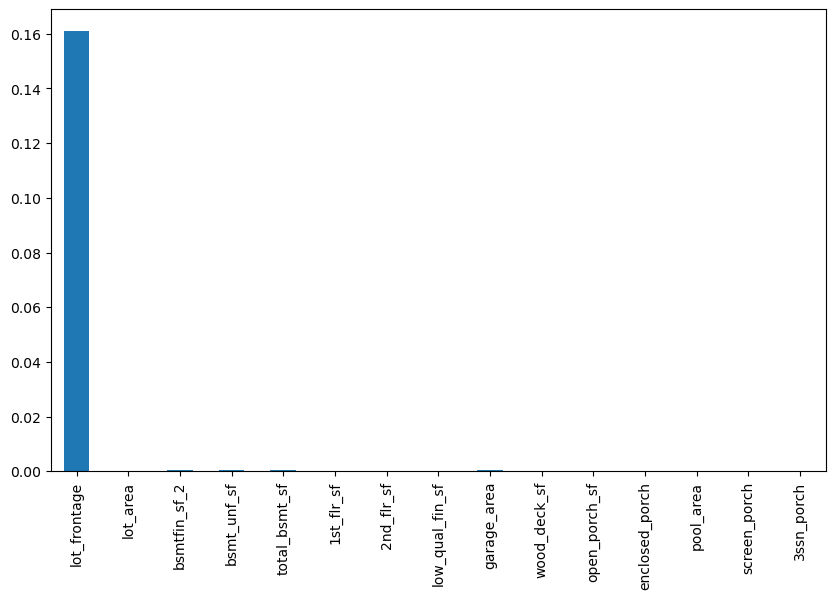

In [57]:
# Create a bar graph of the null percentages
plt.figure(figsize=(10, 6))
null_values_percent.plot(kind='bar')
plt.show()

In [42]:
def print_null_percentages_for_imputation(dataframes_dict, threshold):
    for name, df in dataframes_dict.items():
        print(f"\nDataFrame {name}:")
        null_values_percent = df.isnull().sum() / len(df) * 100
        # Filter out columns with null percentage below the threshold
        null_values_percent = null_values_percent[(null_values_percent < threshold) & (null_values_percent> 0) ]
        print(null_values_percent)



dataframes_dict = {
    'df_size': df_size,
    'df_quality_of_house_vars': df_quality_of_house_vars,
    'df_age_vars': df_age_vars,
    'df_roommage_vars': df_roommage_vars,
    'df_environment_vars': df_environment_vars,
    'df_categories_of_house_vars': df_categories_of_house_vars
}

threshold = 5
print_null_percentages_for_imputation(dataframes_dict, threshold)


DataFrame df_size:
bsmtfin_sf_2     0.048757
bsmt_unf_sf      0.048757
total_bsmt_sf    0.048757
garage_area      0.048757
dtype: float64

DataFrame df_quality_of_house_vars:
bsmt_qual         2.681619
bsmt_cond         2.681619
bsmtfin_type_1    2.681619
bsmtfin_type_2    2.730375
dtype: float64

DataFrame df_age_vars:
Series([], dtype: float64)

DataFrame df_roommage_vars:
bsmt_full_bath    0.097513
bsmt_half_bath    0.097513
dtype: float64

DataFrame df_environment_vars:
Series([], dtype: float64)

DataFrame df_categories_of_house_vars:
mas_vnr_type     1.072647
bsmt_exposure    2.827889
dtype: float64


In [25]:
#use the null values print out to determine if any of the features have so many nulls that imputing them and 
#using 
#use a print out of the number of unqiue values to determine if the data dictionary needs to be consulted to determine if a variable is categorical.

unique_values = df_size.nunique()
print("Number of unique values:\n", unique_values)

null_values = df_size.isnull().sum()
print("\nNumber of null values:\n", null_values)

# Calculate the percentage of null values
null_values_percent = df_size.isnull().sum() / (len(df_size))
print("\nPercentage of null values:\n", null_values_percent)

print("\nData types:\n", df_size.dtypes)




Number of unique values:
 lot_frontage        118
lot_area           1476
bsmtfin_sf_2        205
bsmt_unf_sf         967
total_bsmt_sf       892
1st_flr_sf          915
2nd_flr_sf          504
low_qual_fin_sf      31
garage_area         514
wood_deck_sf        322
open_porch_sf       223
enclosed_porch      159
pool_area            10
screen_porch        100
3ssn_porch           22
dtype: int64

Number of null values:
 lot_frontage       330
lot_area             0
bsmtfin_sf_2         1
bsmt_unf_sf          1
total_bsmt_sf        1
1st_flr_sf           0
2nd_flr_sf           0
low_qual_fin_sf      0
garage_area          1
wood_deck_sf         0
open_porch_sf        0
enclosed_porch       0
pool_area            0
screen_porch         0
3ssn_porch           0
dtype: int64

Percentage of null values:
 lot_frontage       0.160897
lot_area           0.000000
bsmtfin_sf_2       0.000488
bsmt_unf_sf        0.000488
total_bsmt_sf      0.000488
1st_flr_sf         0.000000
2nd_flr_sf         0.

Some square footage variables that have high correlations and therefore violate regression's no multicollinearity requirement. In particular we see a correlation of .81 between the squre footage of the basement and the first floor. We also see a .57 correlation between lot area and lot frontage. Instead of removing one of hte highly correlated vairables, we will perform PCA on all of the square footage variables

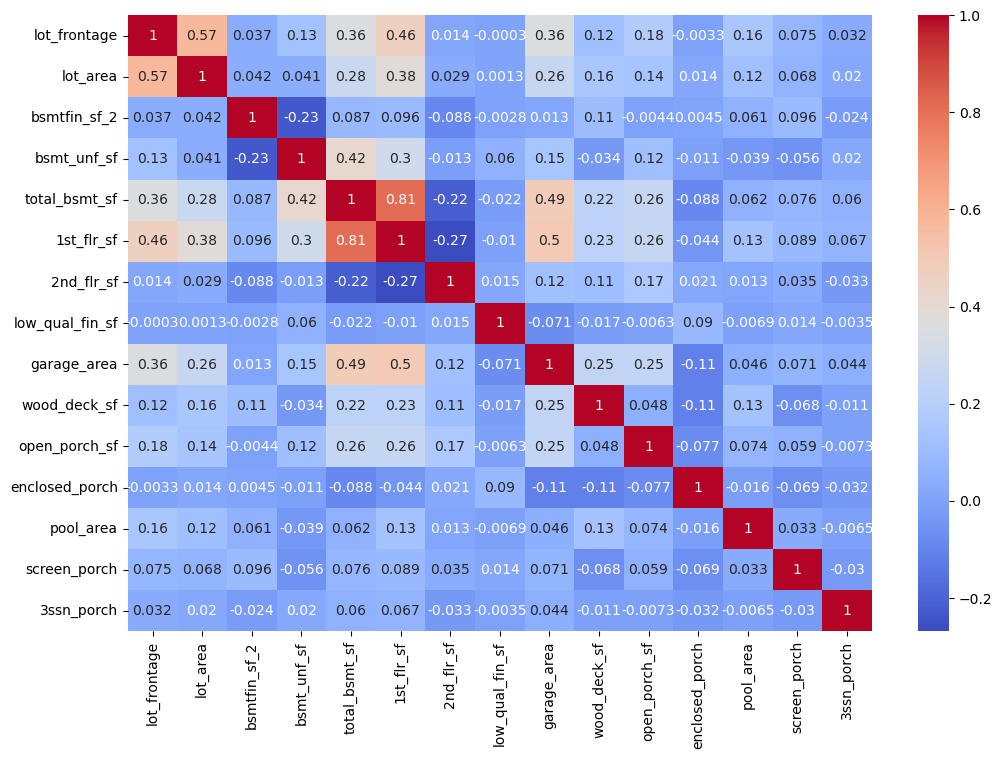

In [14]:
# List of columns to exclude
exclude_columns = ['saleprice','misc_val','saleprice-misc_val']

# Drop the columns
df_size = df_size.drop(columns=exclude_columns)

# Create the heatmap
plt.figure(figsize=(12,8)) # Set the figure size
sns.heatmap(df_size.corr(), annot=True, cmap='coolwarm') # Create a heatmap with correlations
plt.show()


In [15]:
#use the prin
#use a print out of the number of unqiue values to determine if the data dictionary needs to be consulted to determine if a variable is categorical.

unique_values = df_categories_of_house_vars.nunique()
print("Number of unique values:\n", unique_values)

null_values = df_categories_of_house_vars.isnull().sum()
print("\nNumber of null values:\n", null_values)

print("\nData types:\n", df_categories_of_house_vars.dtypes)


Number of unique values:
 saleprice             828
misc_val               28
roof_style              6
roof_matl               6
exterior_1st           15
exterior_2nd           15
mas_vnr_type            4
foundation              6
bsmt_exposure           4
heating                 5
heating_qc              5
central_air             2
electrical              5
garage_type             6
paved_drive             3
ms_subclass            16
bldg_type               5
lot_shape               4
land_contour            4
utilities               3
lot_config              5
land_slope              3
condition_1             9
condition_2             8
house_style             8
saleprice-misc_val    859
dtype: int64

Number of null values:
 saleprice               0
misc_val                0
roof_style              0
roof_matl               0
exterior_1st            0
exterior_2nd            0
mas_vnr_type           22
foundation              0
bsmt_exposure          58
heating                 0


In [16]:
df_quality_of_house_vars.dtypes

saleprice              int64
misc_val               int64
overall_qual           int64
overall_cond           int64
exter_qual            object
exter_cond            object
bsmt_qual             object
bsmt_cond             object
bsmtfin_type_1        object
bsmtfin_type_2        object
kitchen_qual          object
functional            object
fireplace_qu          object
garage_qual           object
garage_finish         object
garage_cond           object
fence                 object
pool_qc               object
saleprice-misc_val     int64
dtype: object

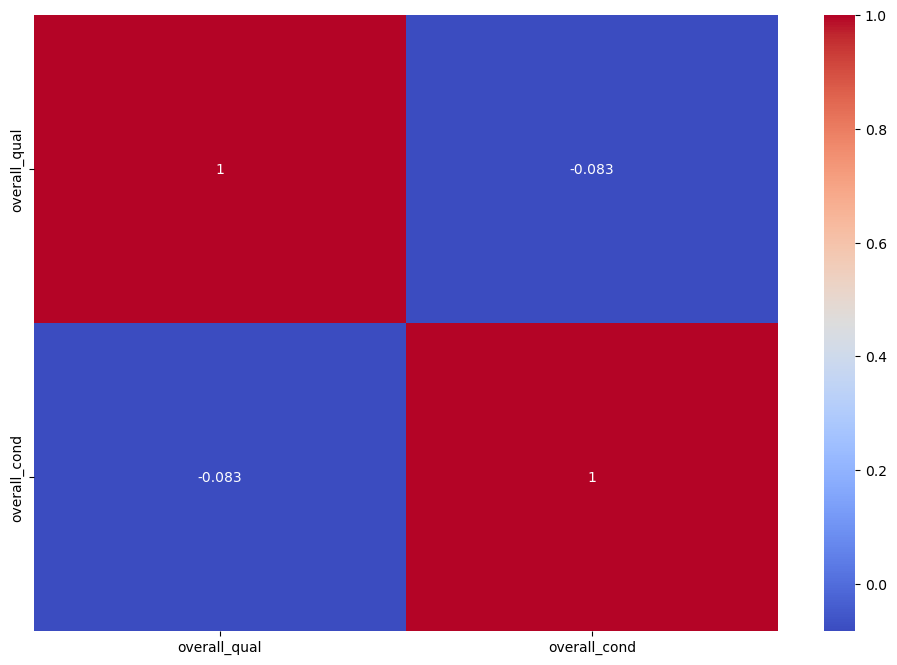

In [17]:
df_quality_of_house_vars_sns = df_quality_of_house_vars[['overall_qual','overall_cond']]

# Create the heatmap
plt.figure(figsize=(12,8)) # Set the figure size
sns.heatmap(df_quality_of_house_vars_sns.corr(), annot=True, cmap='coolwarm') # Create a heatmap with correlations
plt.show()


In [18]:
df_age_vars.dtypes

saleprice               int64
misc_val                int64
year_built              int64
year_remod_add          int64
garage_yr_blt         float64
yr_sold                 int64
mo_sold                 int64
saleprice-misc_val      int64
dtype: object

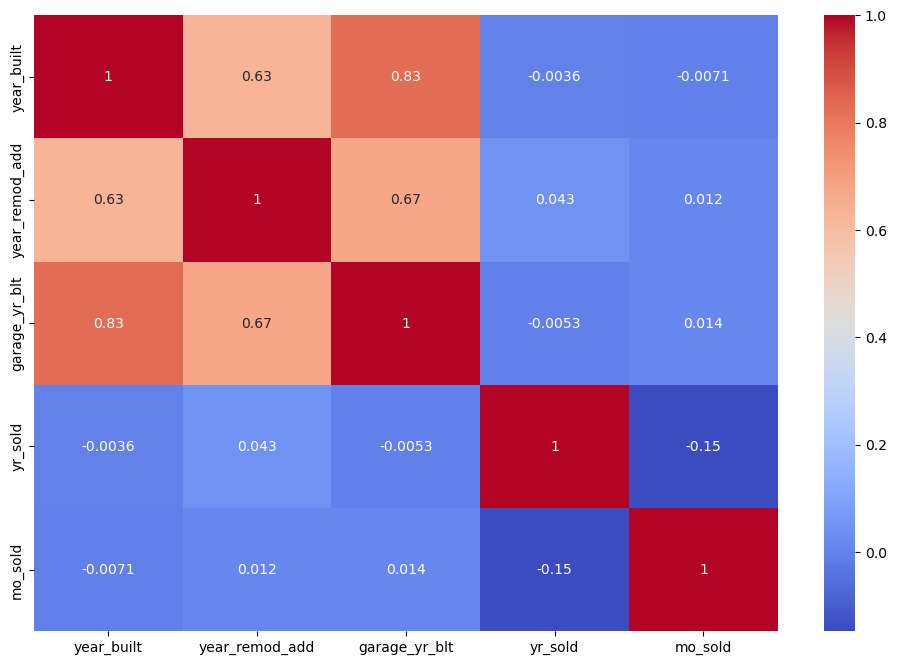

In [19]:
# List of columns to exclude
exclude_columns = ['saleprice','misc_val','saleprice-misc_val']

# Drop the columns
df_age_vars = df_age_vars.drop(columns=exclude_columns)

# Create the heatmap
plt.figure(figsize=(12,8)) # Set the figure size
sns.heatmap(df_age_vars.corr(), annot=True, cmap='coolwarm') # Create a heatmap with correlations
plt.show()


In [20]:
df_roommage_vars.dtypes

saleprice               int64
misc_val                int64
bsmt_full_bath        float64
bsmt_half_bath        float64
full_bath               int64
half_bath               int64
bedroom_abvgr           int64
kitchen_abvgr           int64
totrms_abvgrd           int64
fireplaces              int64
saleprice-misc_val      int64
dtype: object

In [21]:
# List of columns to exclude
exclude_columns = [saleprice','misc_val','saleprice-misc_val']

# Drop the columns
df_roommage_vars = df_roommage_vars.drop(columns=exclude_columns)

# Create the heatmap
plt.figure(figsize=(12,8)) # Set the figure size
sns.heatmap(df_roommage_vars.corr(), annot=True, cmap='coolwarm') # Create a heatmap with correlations
plt.show()


SyntaxError: invalid syntax (3778178381.py, line 2)

In [ ]:
df_environment_vars.dtypes

<font size="8">Section 2</font>
<a id='destination_cell_2'></a>

[Return to Table of Contents](#destination_cell_10)



**we will use a form of robust scaling that is less sensitive to outliers to perform our pca, we will use the interquartile range to reduce our sensitivity**
**we could use the pairplots to identify individual outliers and then drop them by index**
**we could just normalize using standard deviation, and then winsorize the data by dropping all values above a certain SD**
**winsorize the contiuous features to deal with outliers**



To gain confidence in the linear relationship between a categorical predictor variable and a target variable, you can follow these steps:

Visualize the data: Create box plots or violin plots of the target variable for each category of the predictor variable. If there is a linear relationship, you should see a consistent increase or decrease in the median of the target variable as you move from one category to the next.

Statistical tests: Perform an Analysis of Variance (ANOVA) to test if there are significant differences in the mean of the target variable across the categories. If there are significant differences, it suggests that the categorical variable does have an effect on the target variable.


In [ ]:
counts = df['ms_zoning'].value_counts()
counts

**YOU MUST ADD MS_ZONING TO EVERY DF BECAUSE YOU NEED THE INDEXES (ROWS) OF THE "C", "A", "I", "RH", "FV" TO DROP FROM ALL DATAFRAMES

In [ ]:
# Create a boolean mask to drop rwws
mask = df['ms_zoning'].isin(['C (all)', 'A (agr)', 'I (all)', 'RH', 'FV'])

# Use the boolean mask to drop the rows in place
df.drop(df[mask].index, inplace=True)

#confirm rows are dropped
df.shape


In [ ]:
#drop these two columns, they are arbitrary ids given to transactions, cannot possibly predict sales
df.drop(columns = ["pid", "id"], inplace = True)


In [ ]:
df.isna().sum().sort_values(ascending= False)[lambda x: x>100]

In [ ]:
df.isnull().sum()[lambda x: x>0]

In [ ]:
#confirm only rows were dropped
df.shape

In [ ]:
#just drop the rows for features that have less than 3 nulls. No need to impute values for them.
rows_to_drop = df.columns[df.isnull().sum() < 3]
df = df.dropna(subset=rows_to_drop)

In [ ]:
#confirm only rows were dropped
df.shape

In [ ]:
df.isnull().sum()[lambda x: x>0]


In [ ]:
cols_to_drop = df.columns[df.isnull().sum() > 105]
df = df.drop(cols_to_drop, axis=1)


In [ ]:
#confirm columns dropped
df.shape

<font size="8">Section 3</font>
<a id='destination_cell_3'></a>

[Return to Table of Contents](#destination_cell_10)

In [58]:
#Theses are the features we will impute values for
df.isnull().sum()[lambda x: x>0]

lot_frontage       330
alley             1911
mas_vnr_type        22
mas_vnr_area        22
bsmt_qual           55
bsmt_cond           55
bsmt_exposure       58
bsmtfin_type_1      55
bsmtfin_sf_1         1
bsmtfin_type_2      56
bsmtfin_sf_2         1
bsmt_unf_sf          1
total_bsmt_sf        1
bsmt_full_bath       2
bsmt_half_bath       2
fireplace_qu      1000
garage_type        113
garage_yr_blt      114
garage_finish      114
garage_cars          1
garage_area          1
garage_qual        114
garage_cond        114
pool_qc           2042
fence             1651
misc_feature      1986
dtype: int64

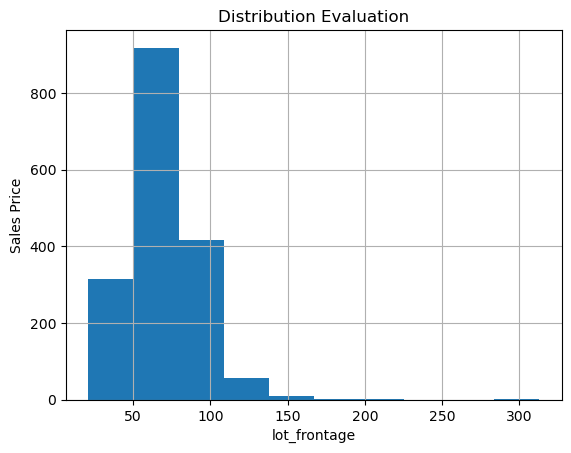

<Figure size 10x10 with 0 Axes>

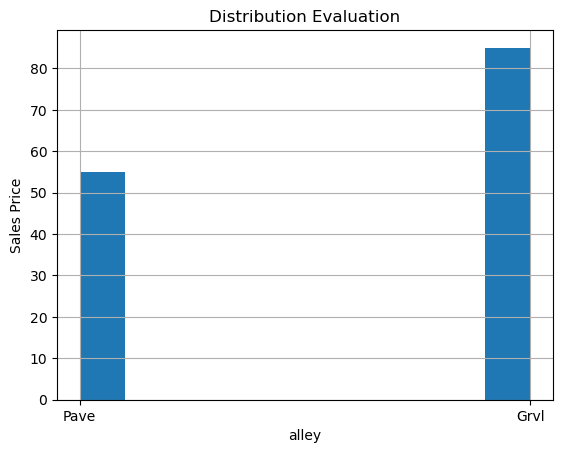

<Figure size 10x10 with 0 Axes>

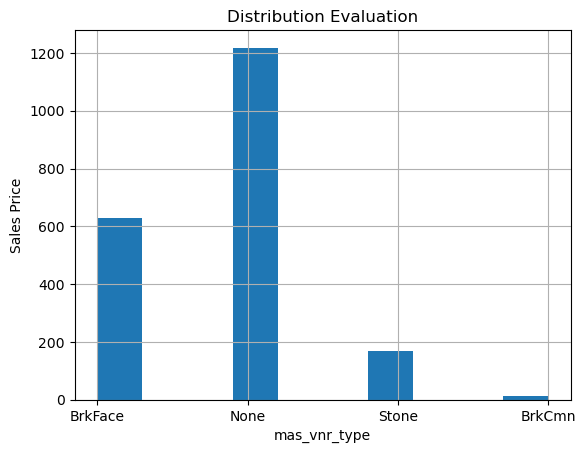

<Figure size 10x10 with 0 Axes>

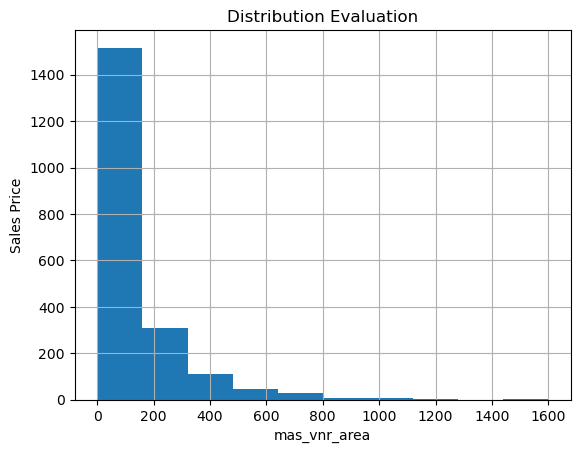

<Figure size 10x10 with 0 Axes>

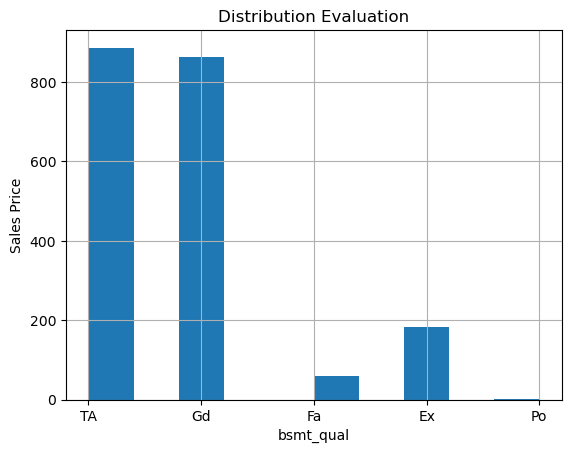

<Figure size 10x10 with 0 Axes>

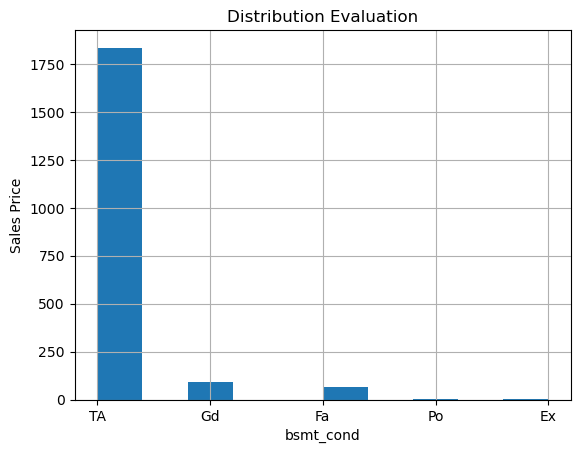

<Figure size 10x10 with 0 Axes>

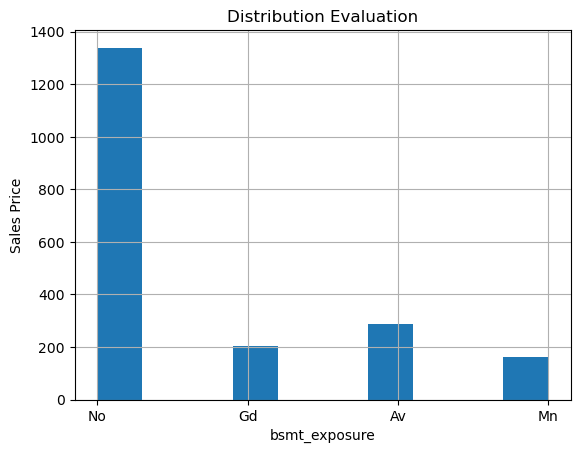

<Figure size 10x10 with 0 Axes>

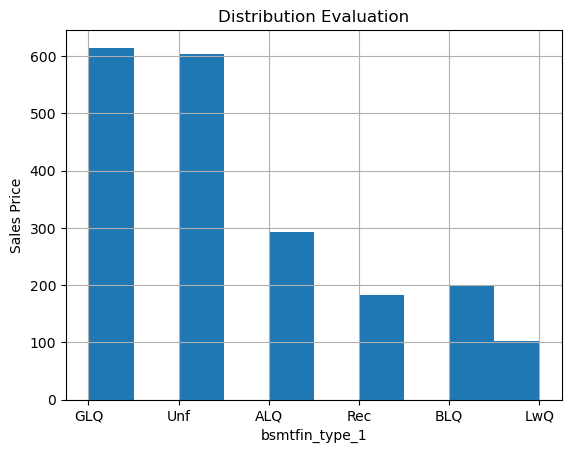

<Figure size 10x10 with 0 Axes>

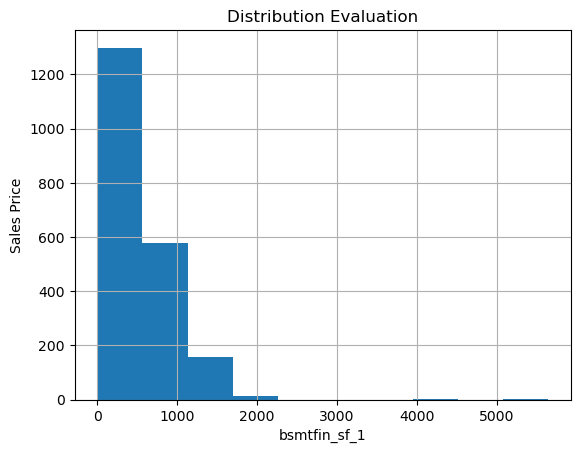

<Figure size 10x10 with 0 Axes>

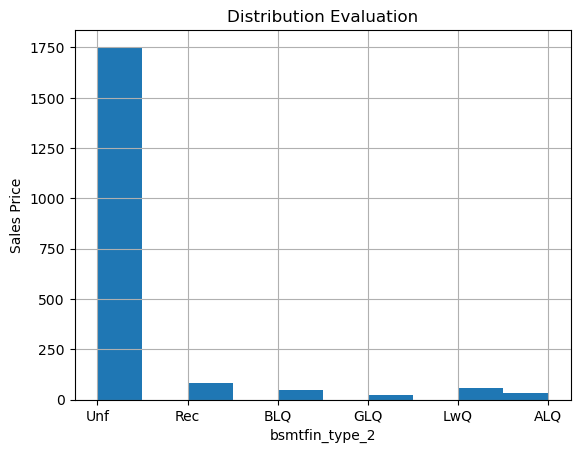

<Figure size 10x10 with 0 Axes>

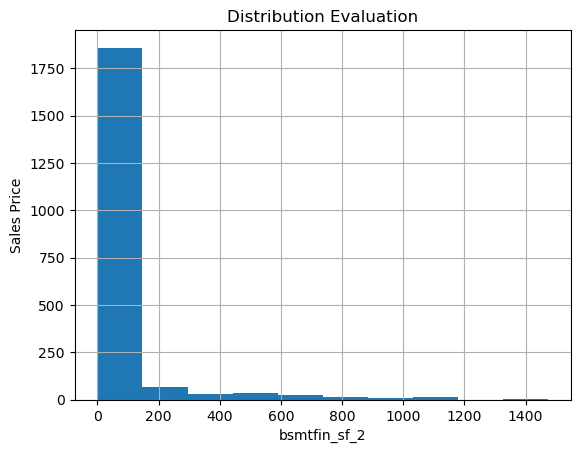

<Figure size 10x10 with 0 Axes>

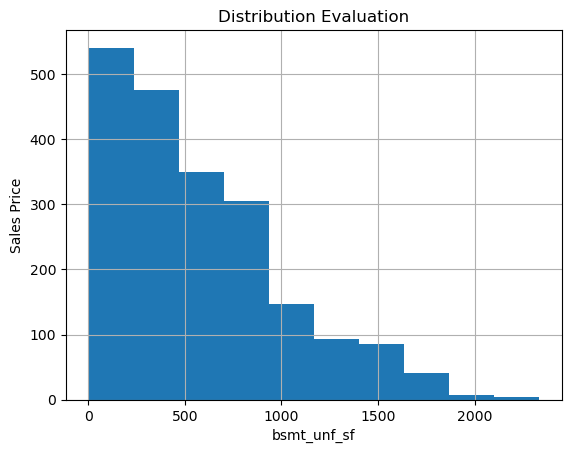

<Figure size 10x10 with 0 Axes>

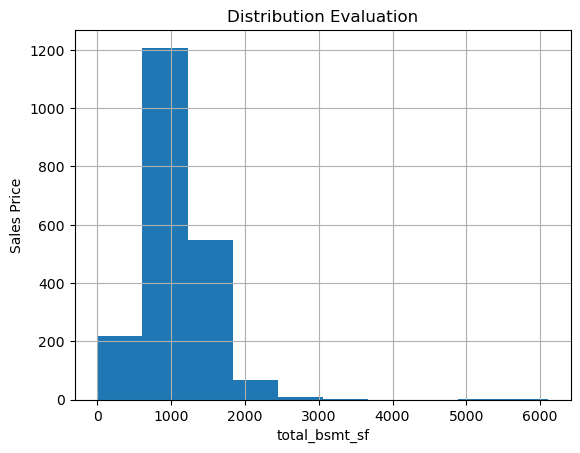

<Figure size 10x10 with 0 Axes>

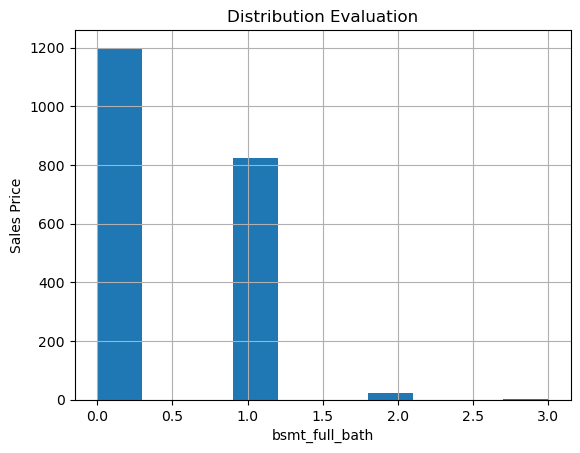

<Figure size 10x10 with 0 Axes>

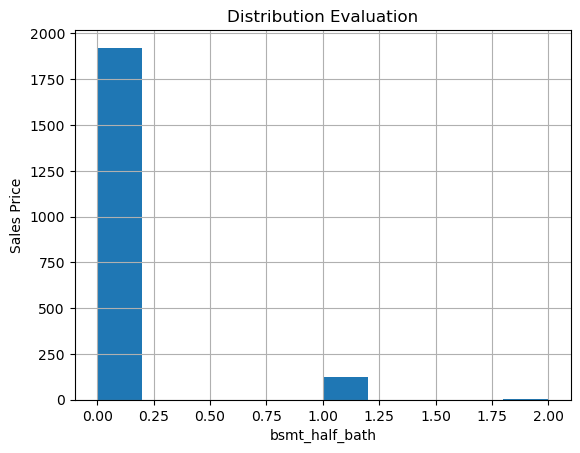

<Figure size 10x10 with 0 Axes>

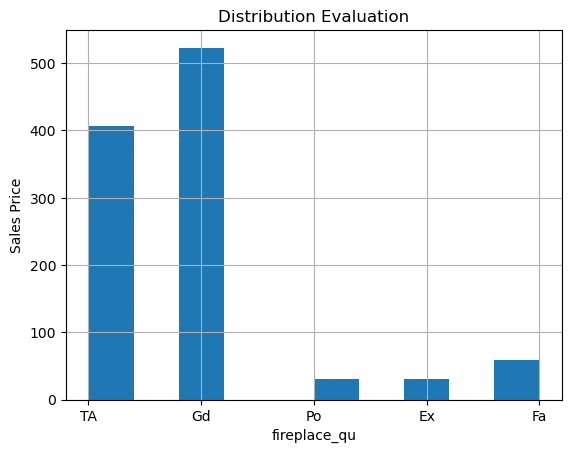

<Figure size 10x10 with 0 Axes>

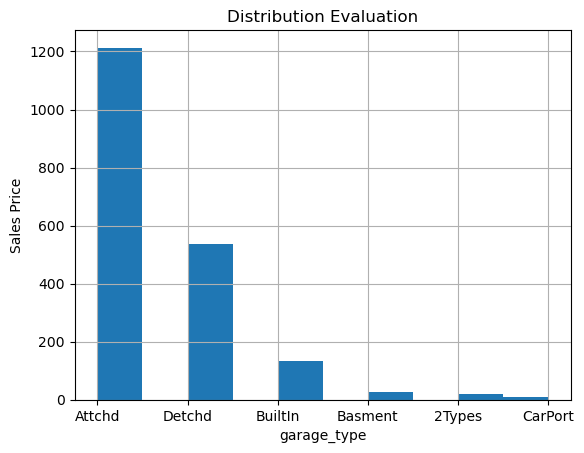

<Figure size 10x10 with 0 Axes>

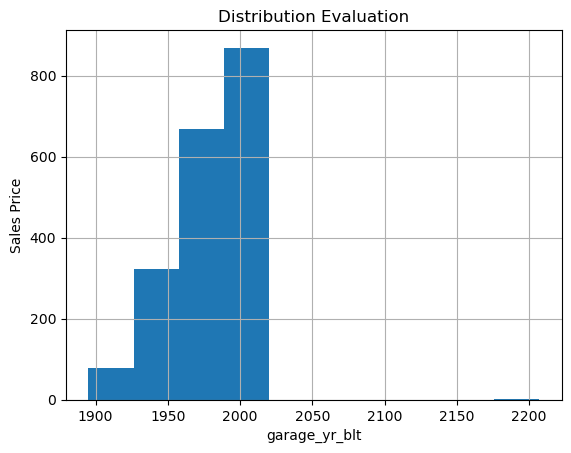

<Figure size 10x10 with 0 Axes>

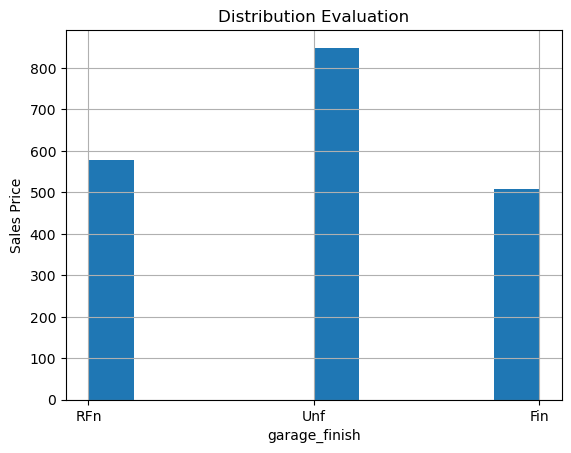

<Figure size 10x10 with 0 Axes>

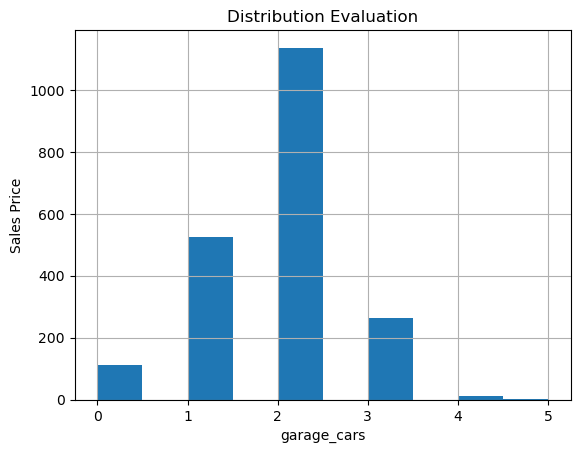

<Figure size 10x10 with 0 Axes>

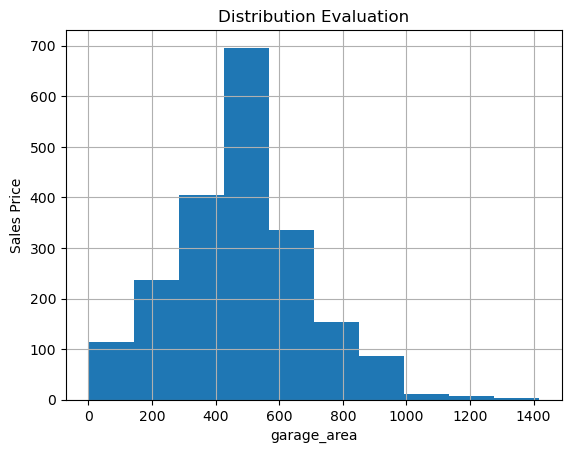

<Figure size 10x10 with 0 Axes>

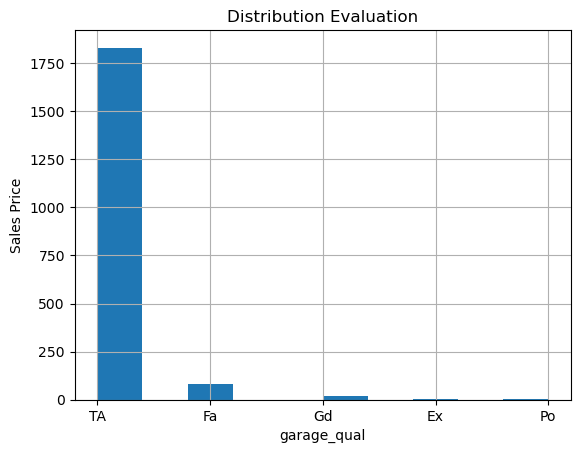

<Figure size 10x10 with 0 Axes>

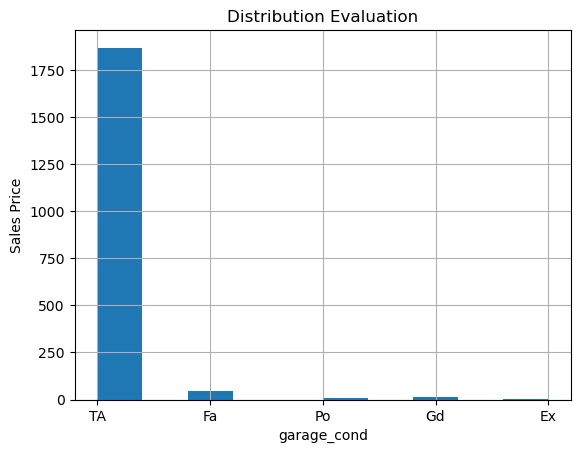

<Figure size 10x10 with 0 Axes>

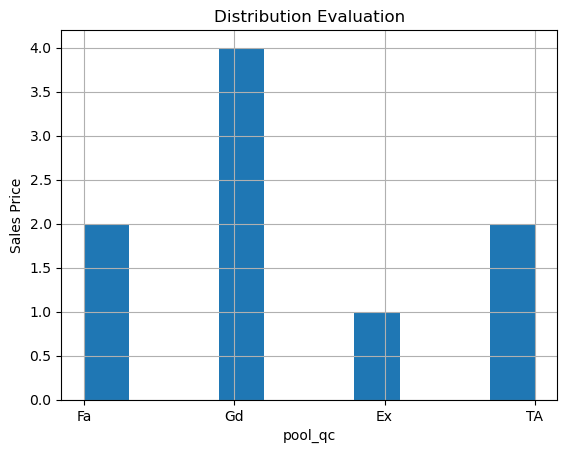

<Figure size 10x10 with 0 Axes>

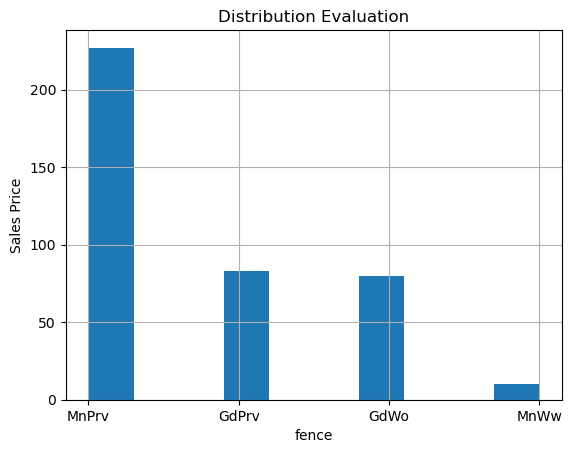

<Figure size 10x10 with 0 Axes>

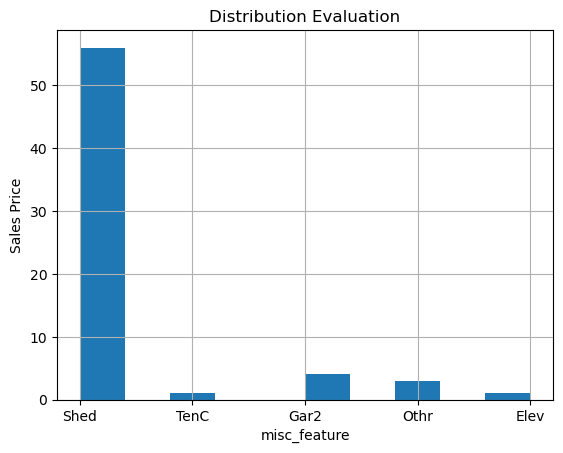

<Figure size 10x10 with 0 Axes>

In [59]:
# Get the column names of columns with missing values
imputable_columns = list(df.isnull().sum()[lambda x: x>0].index)

# Create histograms for each column with missing values
for col in imputable_columns:
    df[col].hist()
    plt.title('Distribution Evaluation')
    plt.xlabel(col)
    plt.ylabel("Sales Price")
    plt.figure(figsize=(.1, .1))
    plt.show()


Impute central tendency measure based on distribution:

mas_vnr_type -->Mode       
mas_vnr_area -->Median    
bsmt_qual -->Mode  
bsmt_cond -->Mode          
bsmt_exposure -->Mode      
bsmtfin_type_1 --> Mode    
bsmtfin_type_2 -->Mode     
garage_type  -->Mode      
garage_yr_blt -->Median
garage_finish -->Mode    
garage_qual -->Mode     
garage_cond -->Mode

<font size="8">Section 4</font>
<a id='destination_cell_4'></a>

[Return to Table of Contents](#destination_cell_10)



In [ ]:
### prepare our train data to split into train/validation
#we must split before we impute to prevent leakage
X = df[["gr_liv_area", "garage_area","neighborhood", "total_bsmt_sf", "1st_flr_sf", "year_built",
             "year_remod_add", "full_bath", "garage_yr_blt", "overall_qual", "ms_zoning",
             "lot_area", "bldg_type", "ms_subclass"]]

y = df['saleprice']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,
                                                 y,
                                                 test_size = 0.2,
                                                 random_state = 42,
                                                 )

In [ ]:
# Define a dictionary that maps column names to their corresponding central tendency measure
impute_methods = {
    'mas_vnr_type': 'mode',
    'mas_vnr_area': 'median',
    'bsmt_qual': 'mode',
    'bsmt_cond': 'mode',
    'bsmt_exposure': 'mode',
    'bsmtfin_type_1': 'mode',
    'bsmtfin_type_2': 'mode',
    'garage_type': 'mode',
    'garage_yr_blt': 'median',
    'garage_finish': 'mode',
    'garage_qual': 'mode',
    'garage_cond': 'mode'
}

# Impute missing values in each column with their corresponding central tendency measure for training data
for col, method in impute_methods.items():
    # Check if the column is present in both X_train and impute_methods
    if col in X_train.columns:
        if method == 'mode':
            # Calculate the mode of the column
            col_mode = X_train[col].mode()[0]

            # Replace missing values with the mode
            X_train[col].fillna(col_mode, inplace=True)
        elif method == 'median':
            # Calculate the median of the column
            col_median = X_train[col].median()

            # Replace missing values with the median
            X_train[col].fillna(col_median, inplace=True)


In [ ]:
# Impute missing values in the validation data
for col, method in impute_methods.items():
    # Check if the column is present in both X_val and impute_methods
    if col in X_val.columns:
        if method == 'mode':
            # Calculate the mode of the column from the training data
            col_mode = X_train[col].mode()[0]

            # Replace missing values with the mode
            X_val[col].fillna(col_mode, inplace=True)
        elif method == 'median':
            # Calculate the median of the column from the training data
            col_median = X_train[col].median()

            # Replace missing values with the median
            X_val[col].fillna(col_median, inplace=True)


In [ ]:
# Re-check to see no null values
for feature in df:
    print(f'There are {df[feature].isnull().sum()} null values in the column {feature} -- type = {df[feature].dtypes}   ')

In [ ]:
# Re-check to see no null values for imputed features from our X_train dataset
for feature in X_train:
    print(f'There are {X_train[feature].isnull().sum()} null values in the column {feature} -- type = {X_train[feature].dtypes}   ')

In [ ]:
# Re-check to see no null values for imputed features from our X_val dataset
for feature in X_val:
    print(f'There are {X_train[feature].isnull().sum()} null values in the column {feature} -- type = {X_train[feature].dtypes}   ')

<font size="8">Section 5</font>
<a id='destination_cell_5'></a>

[Return to Table of Contents](#destination_cell_10)





In [ ]:
#get numeric cols
numeric = [col for col in X_train._get_numeric_data().columns]

#get non-numeric cols 
categories = X_train.select_dtypes(include = 'object').columns

In [ ]:
ohe = OneHotEncoder(drop = 'if_binary',
                   sparse_output = False,
                   handle_unknown = 'ignore')

ctx = ColumnTransformer(
    transformers =[
        ('ohe', ohe, categories),
        ('ss', StandardScaler(), numeric)
    ], remainder = 'passthrough', verbose_feature_names_out=False)

In [ ]:
# Fit the ColumnTransformer to the training data
ctx.fit(X_train)

# Transform the training data
X_train_transformed = ctx.transform(X_train)

# Transform the validation data
X_val_transformed = ctx.transform(X_val)


In [ ]:
# Get the transformed column names
transformed_columns = ctx.get_feature_names_out()

# Create a DataFrame from the transformed data with the column names
df_transformed = pd.DataFrame(X_train_transformed, columns=transformed_columns)




<font size="8">Section 6</font>
<a id='destination_cell_6'></a>
[Return to Table of Contents](#destination_cell_10)



In [ ]:
lr = LinearRegression()


In [ ]:
# Combine the ColumnTransformer and LinearRegression model into a pipeline
lr_pipe = Pipeline(steps=[
    ('ctx', ctx),
    ('lr', lr)
])

# Fit the pipeline to the training data
lr_pipe.fit(X_train, y_train)

In [ ]:
# get the coefficients and intercept
coefficients = lr_pipe.named_steps['lr'].coef_
intercept = lr_pipe.named_steps['lr'].intercept_

# print the equation
equation = "y = " + str(intercept)
for i, coef in enumerate(coefficients):
    equation += " + " + str(coef) + " * x" + str(i+1)
print(equation)


In [ ]:
y_pred = lr_pipe.predict(X_val)
residuals=y_pred - y_val
plt.hist(residuals, bins = 20);

In [ ]:
# Looks random

plt.scatter(y_pred, residuals, s = 1)
plt.axhline(0, color = 'orange');

In [ ]:
cross_val_score(lr_pipe, X_train, y_train)


In [ ]:
scores = cross_val_score(lr_pipe, X_train, y_train)
std_dev = np.std(scores)
std_dev

In [ ]:
cross_val_score(lr_pipe, X_train, y_train).mean()


In [ ]:
lr_pipe.score(X_train, y_train)

In [ ]:
lr_pipe.score(X_val, y_val)


In [ ]:
#RMSE
mean_squared_error(y_train, lr_pipe.predict(X_train), squared = False)

In [ ]:
#RMSE
mean_squared_error(y_val, lr_pipe.predict(X_val), squared = False)

<font size="8">Section 7</font>
<a id='destination_cell_7'></a>

[Return to Table of Contents](#destination_cell_10)

In [ ]:
#instantiate it
rg_pipe = Pipeline(
    steps = [
        ('ctx', ctx),
        ('rg', Ridge(alpha = 10))
    ]
)

#fit it!
rg_pipe.fit(X_train, y_train)

In [ ]:
y_pred_rg = rg_pipe.predict(X_val)

In [ ]:
y_pred_rg = rg_pipe.predict(X_val)
residuals_rg=y_pred_rg - y_val
plt.hist(residuals_rg, bins = 20);

In [ ]:
# Looks random

plt.scatter(y_pred_rg, residuals_rg, s = 1)
plt.axhline(0, color = 'green');

In [ ]:
cross_val_score(rg_pipe, X_train, y_train)

In [ ]:
cross_val_score(rg_pipe, X_train, y_train).mean()

In [ ]:
scores_rg = cross_val_score(rg_pipe, X_train, y_train)
std_dev_rg = np.std(scores_rg)
std_dev_rg

In [ ]:
rg_pipe.score(X_train, y_train)

In [ ]:
rg_pipe.score(X_val, y_val)

In [ ]:
#RMSE
mean_squared_error(y_train, rg_pipe.predict(X_train), squared = False)

In [ ]:
#RMSE
mean_squared_error(y_val, rg_pipe.predict(X_val), squared = False)

<font size="8">Section 8</font>
<a id='destination_cell_8'></a>

[Return to Table of Contents](#destination_cell_10)

In [ ]:
#instantiate it
lasso_pipe = Pipeline(
    steps = [
        ('ctx', ctx),
        ('lasso', Lasso(alpha=5.0))
    ]
)

#fit it!
lasso_pipe.fit(X_train, y_train)

In [ ]:
y_pred_lasso = lasso_pipe.predict(X_val)


In [ ]:
y_pred_lasso = lasso_pipe.predict(X_val)
residuals_lasso = y_pred_lasso - y_val
plt.hist(residuals_lasso, bins = 20);

In [ ]:
# Looks random

plt.scatter(y_pred_lasso, residuals_lasso, s = 1)
plt.axhline(0, color = 'red');

In [ ]:
cross_val_score(lasso_pipe, X_train, y_train)

In [ ]:
cross_val_score(lasso_pipe, X_train, y_train).mean()

In [ ]:
scores_lasso = cross_val_score(lasso_pipe, X_train, y_train)
std_dev_lasso = np.std(scores_lasso)
std_dev_lasso

In [ ]:
lasso_pipe.score(X_train, y_train)

In [ ]:
lasso_pipe.score(X_val, y_val)

In [ ]:
#RMSE
mean_squared_error(y_train, lasso_pipe.predict(X_train), squared = False)

In [ ]:
#RMSE
mean_squared_error(y_val, lasso_pipe.predict(X_val), squared = False)


<font size="8">Section 9</font>
<a id='destination_cell_9'></a>

[Return to Table of Contents](#destination_cell_10)

In [ ]:
#instantiate it
elastic_pipe = Pipeline(
    steps = [
        ('ctx', ctx),
        ('elastic', ElasticNet(alpha=1.0))
    ]
)

#fit it!
elastic_pipe.fit(X_train, y_train)

In [ ]:
y_pred_elastic = elastic_pipe.predict(X_val)


In [ ]:
y_pred_elastic = lasso_pipe.predict(X_val)
residuals_elastic= y_pred_lasso - y_val
plt.hist(residuals_elastic, bins = 20);

In [ ]:
# Looking for randomness!

plt.scatter(y_pred_elastic, residuals_elastic, s = 1)
plt.axhline(0, color = 'purple');

In [ ]:
cross_val_score(elastic_pipe, X_train, y_train)

In [ ]:
scores_elastic = cross_val_score(elastic_pipe, X_train, y_train)
std_dev_elastic = np.std(scores_elastic)
std_dev_elastic

In [ ]:
cross_val_score(elastic_pipe, X_train, y_train).mean()

In [ ]:
elastic_pipe.score(X_train, y_train)

In [ ]:
elastic_pipe.score(X_val, y_val)

In [ ]:
#RMSE
mean_squared_error(y_train, elastic_pipe.predict(X_train), squared = False)

In [ ]:
#RMSE
mean_squared_error(y_val, elastic_pipe.predict(X_val), squared = False)